# Analyzing Textual Data for Early Detection of Suicide and Depression 


In [19]:
import numpy as np
import pandas as pd

import copy
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
import string

from nltk.tokenize import word_tokenize 
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras_preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors

In [20]:
data=pd.read_csv("DL project dataset.csv",encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [21]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
data.columns = DATASET_COLUMNS

In [22]:
data.describe(include='all')

,target,ids,date,flag,user,TweetText
count,1.599999e+06,1.599999e+06,1599999,1599999,1599999,1599999
unique,NaN,NaN,774362,1,659775,1581465
top,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,20,1599999,549,210
mean,2.000001e+00,1.998818e+09,NaN,NaN,NaN,NaN
std,2.000001e+00,1.935757e+08,NaN,NaN,NaN,NaN
min,0.000000e+00,1.467811e+09,NaN,NaN,NaN,NaN
25%,0.000000e+00,1.956916e+09,NaN,NaN,NaN,NaN
50%,4.000000e+00,2.002102e+09,NaN,NaN,NaN,NaN
75%,4.000000e+00,2.177059e+09,NaN,NaN,NaN,NaN


In [23]:
data.dtypes

target        int64
ids           int64
date         object
flag         object
user         object
TweetText    object
dtype: object

In [24]:
import copy
data_ = copy.deepcopy(data)

positif_data = data_[data_.target==4].iloc[:80000,:]
negative_data = data_[data_.target==0].iloc[:80000,:]

sub_data = pd.concat([positif_data,negative_data],axis=0)

# Data exploration

4    800000
0    799999
Name: target, dtype: int64

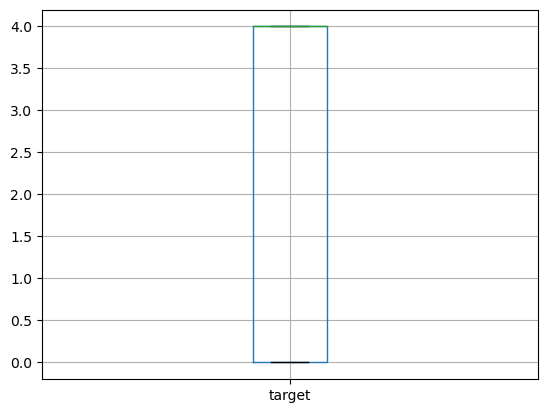

In [25]:
data.boxplot(column='target')
data_target=data.groupby('target')
data['target'].value_counts()

There is a certain time period where the frequency of people sharing depressed/suicidal tweets.

In [26]:
data_ = {'target': data['target'], 'date': data['date']}
df = pd.DataFrame(data_)
df.head()

,target,date
0,0,Mon Apr 06 22:19:49 PDT 2009
1,0,Mon Apr 06 22:19:53 PDT 2009
2,0,Mon Apr 06 22:19:57 PDT 2009
3,0,Mon Apr 06 22:19:57 PDT 2009
4,0,Mon Apr 06 22:20:00 PDT 2009


In [27]:
df['date'] = pd.to_datetime(df['date'])
hour = [ df['date'][i].hour for i in range(len(df['date'])) ]
df['hour'] = hour
df.head()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,target,date,hour
0,0,2009-04-06 22:19:49,22
1,0,2009-04-06 22:19:53,22
2,0,2009-04-06 22:19:57,22
3,0,2009-04-06 22:19:57,22
4,0,2009-04-06 22:20:00,22


In [28]:
hour_data = {'0': [0]*24, '2': [0]*24, '4': [0]*24}
for i in range(len(df['hour'])):
    target = str(df['target'][i])
    hour = int(df['hour'][i])
    hour_data[target][hour] += 1

In [29]:
hour_data = [hour_data['0'], hour_data['2'], hour_data['4']]
# Transpose
hour_data = list(map(list,zip(*hour_data)))

In [30]:
df1 = pd.DataFrame(hour_data,index = [i for i in range(24)],columns=['negative', 'neutral', 'positive'])

<Axes: >

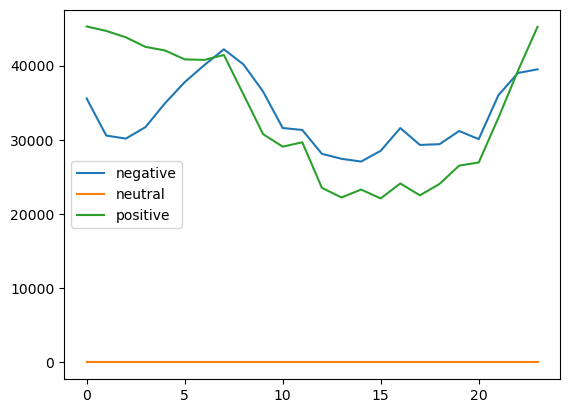

In [31]:
df1.plot()

In [32]:
positive_at_count = 0
negative_at_count = 0
TweetTextList = list(sub_data['TweetText'])
targetList = list(sub_data['target'])
for i in range(len(sub_data['TweetText'])):
    if TweetTextList[i].find('@') != -1:
        if targetList[i] == 4:
            positive_at_count += 1
        else:
            negative_at_count += 1
at_counts = [positive_at_count, negative_at_count]

<BarContainer object of 2 artists>

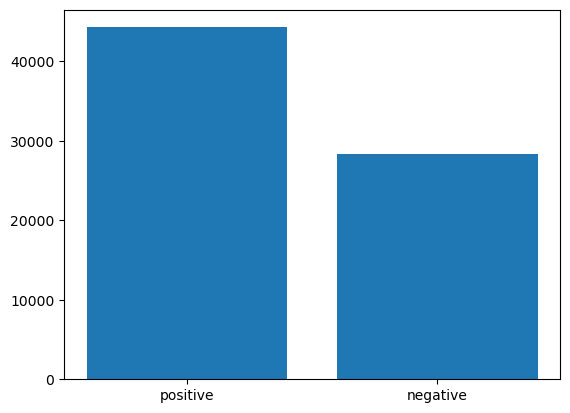

In [33]:
names = ['positive', 'negative']
values = [positive_at_count, negative_at_count]
plt.bar(names, values)

In [ ]:

newdata = copy.deepcopy(sub_data)
newdata.drop(['ids','date','flag','user'],axis = 1,inplace = True)

####  Finding the most repeated words.

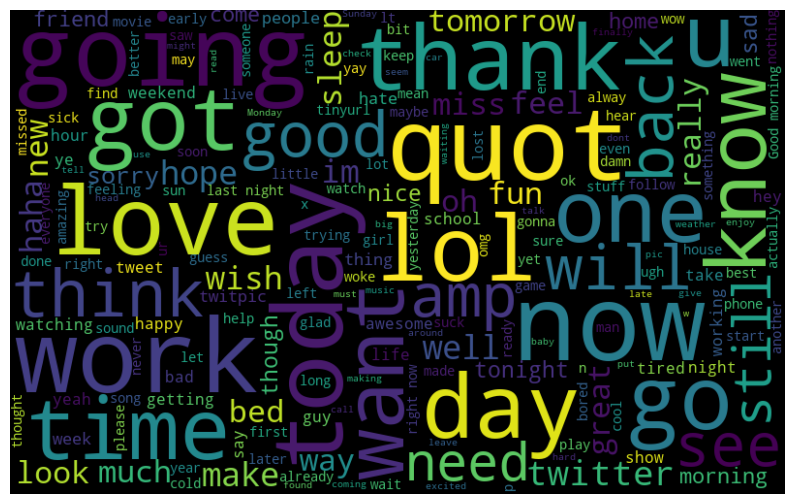

In [35]:
all_words = ' '.join([text for text in newdata['TweetText']])
wordcloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Finding the most repeated positive words.

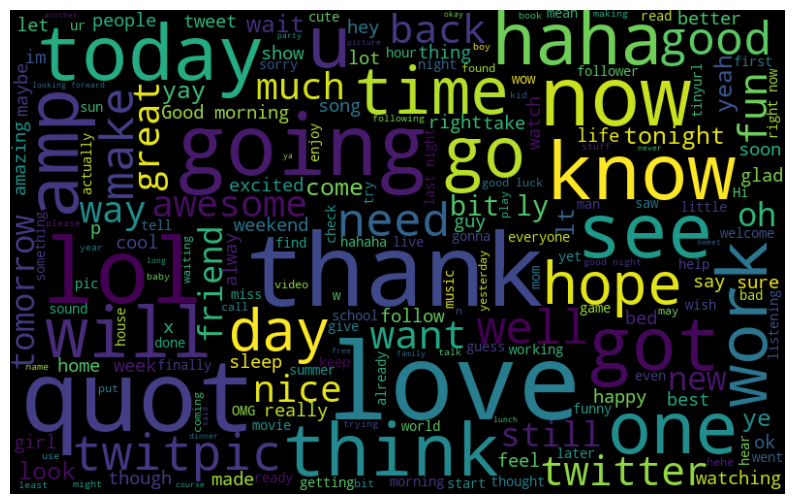

In [36]:
positive_words = ' '.join([text for text in data['TweetText'][data['target']==4]])
wordcloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(positive_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

#### Finding the most repeated negative words.

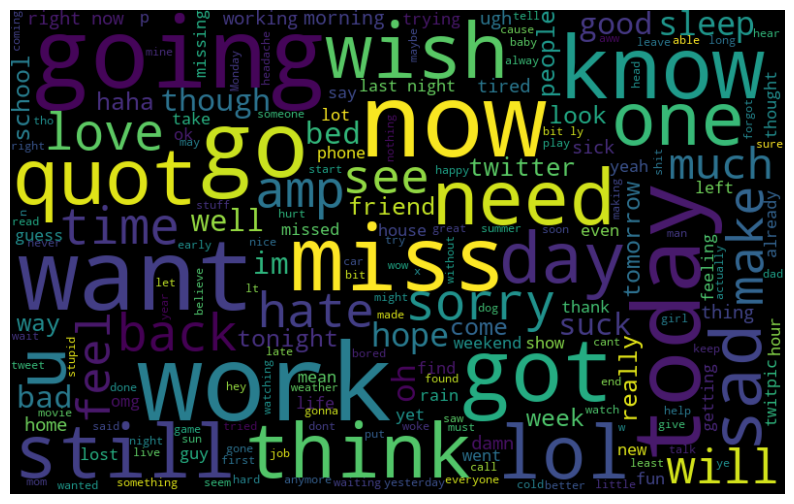

In [37]:
negative_words = ' '.join([text for text in data['TweetText'][data['target']==0]])
wordcloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

# Data preprocessing

In [38]:
positif_data = data[data.target==4].iloc[:10000,:]
print(positif_data.shape)
negative_data = data[data.target==0].iloc[:10000,:]
print(negative_data.shape)
data = pd.concat([positif_data,negative_data],axis = 0)
print(data.shape)
data.head()

(10000, 6)
(10000, 6)
(20000, 6)


,target,ids,date,flag,user,TweetText
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [39]:
df = data.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['TweetText', 'label']]
df.dropna(inplace=True)
df.head()

,TweetText,label
650,56 min till home time and counting! I have a c...,0
802040,"@missygail Shouldn't argue, since you know I'm...",0
808667,@mileycyrus you where amazing on gma. thanks s...,0
801113,"ok so the twilight book is pretty addicting, c...",0
3902,"@Rammi I love Chinatown and its cheap stuffs, ...",0


In [40]:
col_names = ['id', 'text']
df2 = pd.read_csv(('depressive_tweets_processed.csv'), sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)

In [41]:
df2['label'] = 1
df2 = df2[['text', 'label']]
data = pd.concat([df,df2])
data = data.sample(frac=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10345 entries, 1885 to 2098
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetText  8000 non-null   object
 1   label      10345 non-null  int64 
 2   text       2313 non-null   object
dtypes: int64(1), object(2)
memory usage: 323.3+ KB


In [47]:
# Removing the twitter handles 
data['Clean_TweetText'] = data['TweetText'].str.replace("@", "", regex=True) 
# Removing links
data['Clean_TweetText'] = data['Clean_TweetText'].str.replace(r"http\S+", "", regex=True) 
# Removing Punctuations, Numbers, and Special Characters
data['Clean_TweetText'] = data['Clean_TweetText'].str.replace("[^a-zA-Z]", " ", regex=True) 
# Remove stop words

#nltk.download('stopwords')
stop_words=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stop_words])
    return clean_text
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda text : remove_stopwords(str(text).lower()))
data.head()

,TweetText,label,text,Clean_TweetText
1885,Downy weather Where's the summer?,0,NaN,downy weather summer
1122,NaN,1,"Early bird, but depression turned me into an u...",nan
5130,baahh??? SNOW?!?! ..... gross...,0,NaN,baahh snow gross
2404,Tonight's Gyratory System show at the vibe bar...,0,NaN,tonight gyratory system show vibe bar electron...
563,NaN,1,"Every time I see my Facebook profile, I imagin...",nan


In [48]:
#nltk.download('punkt')
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: nltk.word_tokenize(x))
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x]))
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Tokenisation

In [49]:
MAX_NUM_WORDS = 10000
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(negative_words)

In [50]:
word_vector = tokenizer.texts_to_sequences(negative_words)
word_index = tokenizer.word_index

In [51]:
vocab_size = len(word_index)
vocab_size

121

## TF-IDF model

In [52]:
corpus = data['Clean_TweetText'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tdidf_tensor = tfidf.fit_transform(corpus)

In [53]:
tdidf_tensor.shape

(10345, 10000)

In [54]:
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, data['label'].values, test_size=0.3)

In [56]:
baseline_model = SVC()
baseline_model.fit(x_train, y_train)

SVC()

In [57]:
predictions = baseline_model.predict(x_test)
accuracy_score(y_test, predictions)

0.9951675257731959

In [58]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.99374   0.99686      2398
           1    0.97920   1.00000   0.98949       706

    accuracy                        0.99517      3104
   macro avg    0.98960   0.99687   0.99318      3104
weighted avg    0.99527   0.99517   0.99519      3104

